In [1]:
import pandas as pd
import numpy as np
import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.options.display.max_seq_items = 2000

# import python modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models import random_forest_model as model

# Random Forest and Gradient Boosting

### Data Preparation

In [2]:
journey_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2016.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2018.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2019.csv', parse_dates=['end_date', 'start_date'], index_col=0)

In [3]:
journey_train = pd.concat([journey_16, journey_17, journey_18])
journey_test = journey_19.copy()

x_train, y_train, x_test, y_test = model.train_test_split(journey_train, journey_test)

In [4]:
print("Shape x_train and y_train",  x_train.shape, y_train.shape)

Shape x_train and y_train (305404, 104) (305404,)


In [5]:
y_train.head()

0    60
1    69
2    14
3    22
4    11
Name: demand, dtype: int64

### Model 1: Random Forest, with hyperparameter tuning

In [33]:
# hyperparameter tuning
random_search = model.hyper_param_tuning(x_train, y_train, 10, 3)

# print or log all tried parameters and their scores
print(pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']])

# predict on the test set using the best model
rf = random_search.best_estimator_
y_pred = rf.predict(x_test)

KeyboardInterrupt: 

In [ ]:
# save the model
joblib.dump(rf, '../models/random_forest.pkl')

In [ ]:
# evaluation metrics
rmse, mae, r2 = model.evaluation_metrics(y_test_d, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 53.480270410831665
MAE: 26.646721254924326
R2 Score: 0.8514260488261709


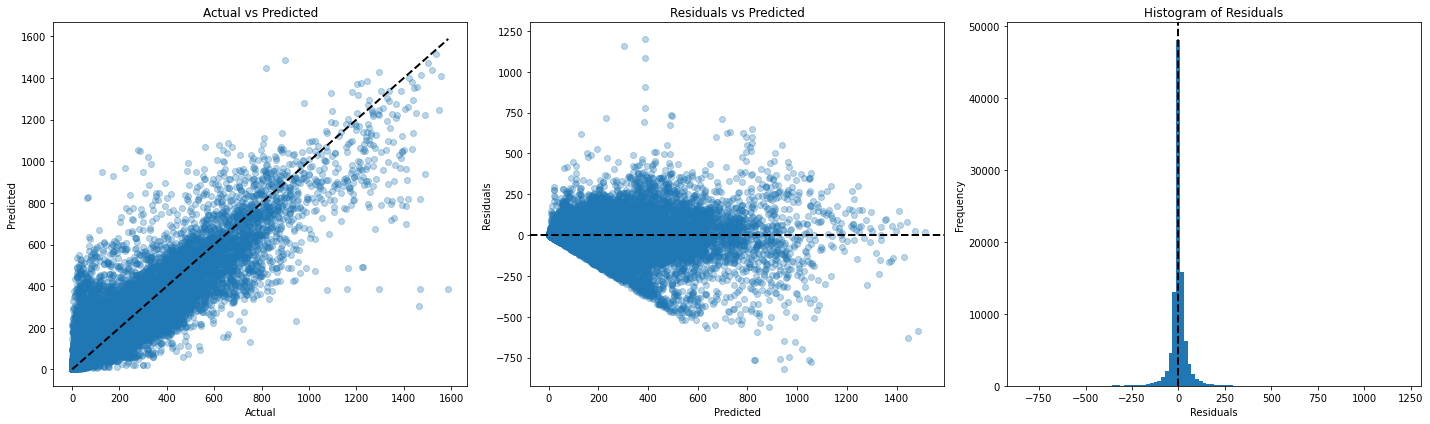

In [ ]:
# evaluation visualisation
model.evaluation_vis(y_test, y_pred)

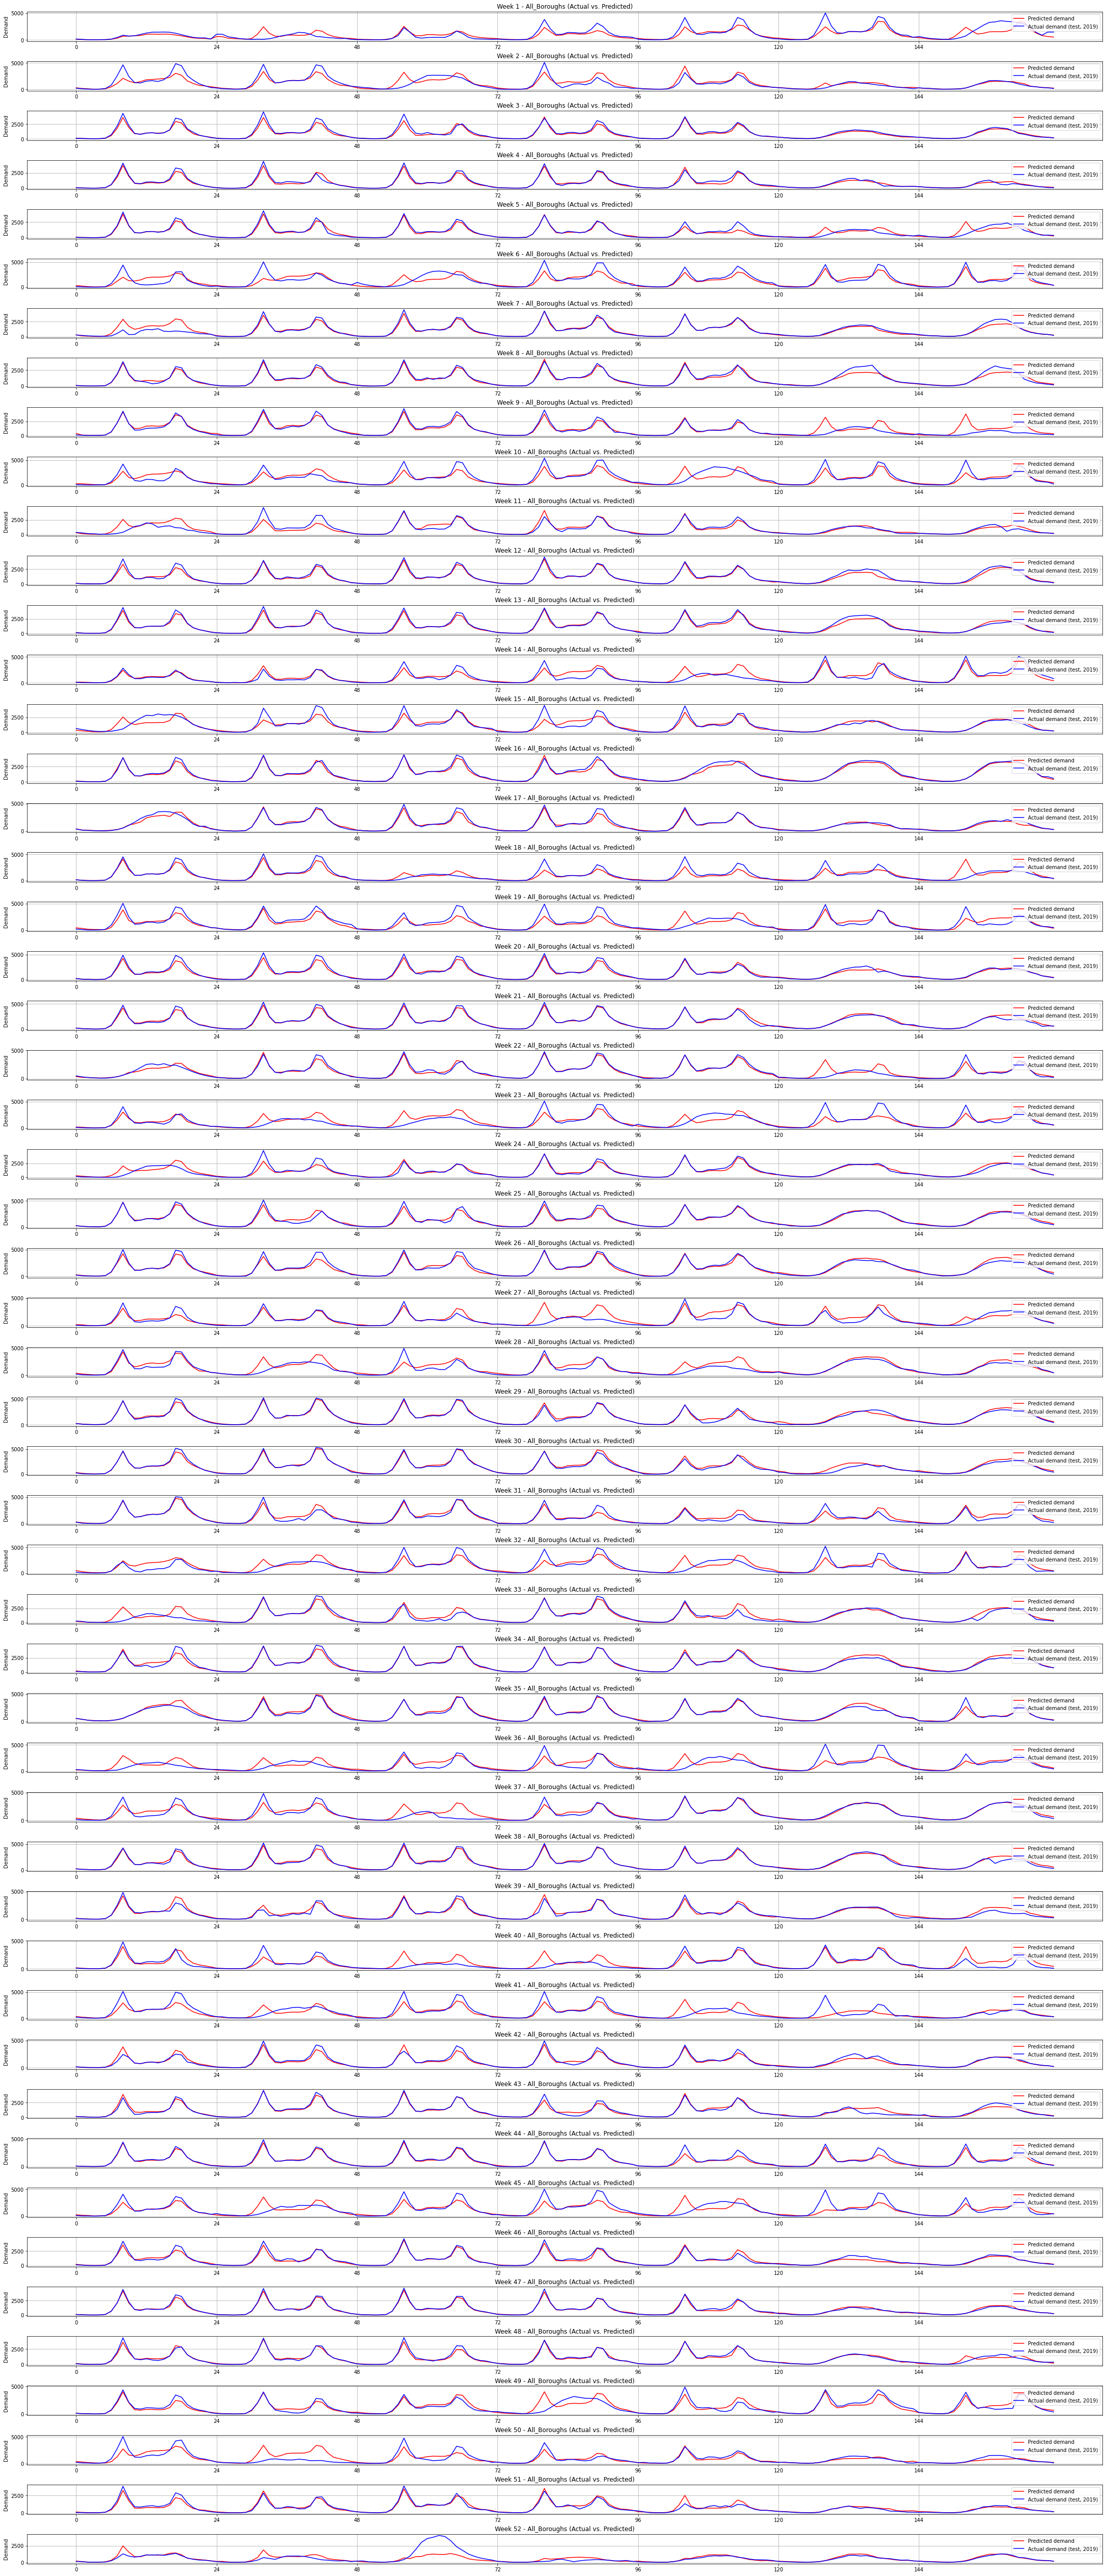

In [ ]:
# visualisation: pred vs actual
model.evaluation_actual_vs_predicted(y_test, y_pred, journey_test, 'All_Boroughs', 'model_random_forest_1')

In [ ]:
# visualisation: pred vs actual per borough
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    model.evaluation_actual_vs_predicted(y_test, y_pred, journey_test, borough)

In [ ]:
# investigate elements with highest errors
df_errors = model.get_enornous_entrie(y_test, y_pred, x_test)
df_errors.head(10)


,Actual,Predicted,Error,day_of_week,hour,month,bank_holiday,start_borough_Westminster
100399,1588,406.8075,1181.1925,2,15,12.0,1.0,1
100387,1470,398.7675,1071.2325,2,14,12.0,1.0,1
100411,1464,395.2550,1068.7450,2,16,12.0,1.0,1
96237,126,1032.0875,906.0875,1,17,12.0,0.0,1
100375,1296,393.3600,902.6400,2,13,12.0,1.0,1
51682,278,1105.3500,827.3500,3,17,7.0,0.0,1
96249,172,976.6700,804.6700,1,18,12.0,0.0,1
100363,1162,370.8875,791.1125,2,12,12.0,1.0,1
71079,66,855.3200,789.3200,2,17,9.0,0.0,1
18598,1230,460.9400,769.0600,4,14,3.0,0.0,1


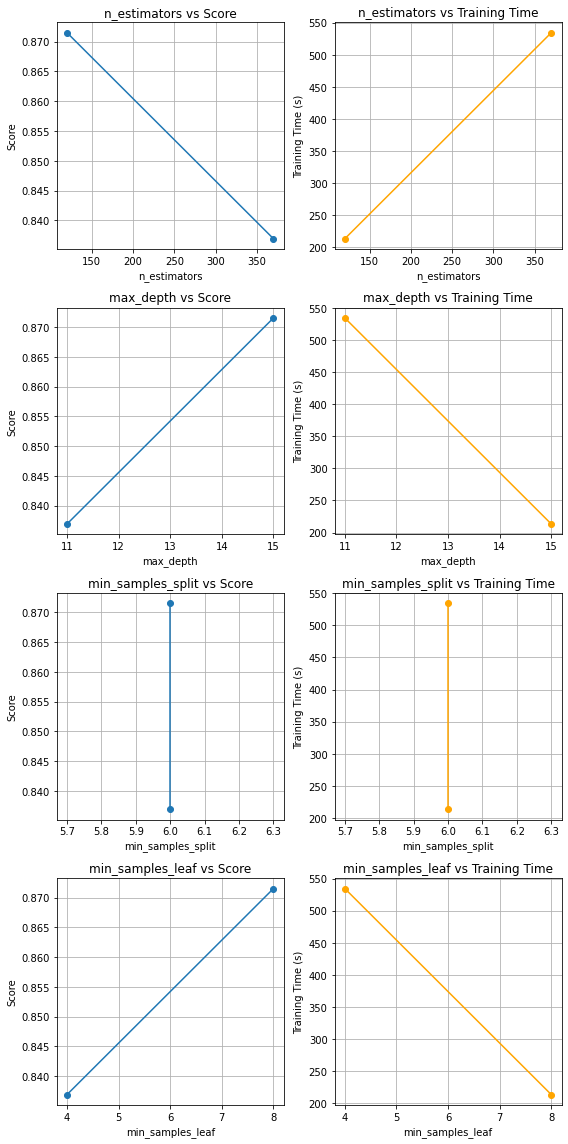

In [ ]:
# visualize random search results
model.visualize_random_search_rf(random_search)

### Model 2: Random Forest, Log-Transformed

In [ ]:
# Apply a log transformation to the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Fit the model on the transformed target
rf.fit(x_train, y_train_log)

# Predict on the test set
y_pred_log = rf.predict(x_test)

# Transform the predictions back to the original scale
# y_pred_log = np.expm1(y_pred_log)

In [ ]:
# evaluation metrics
rmse, mae, r2 = model.evaluation_metrics(y_test_log, y_pred_log)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 146.97146631851587
MAE: 86.67906134835174
R2 Score: -10964.673961471624


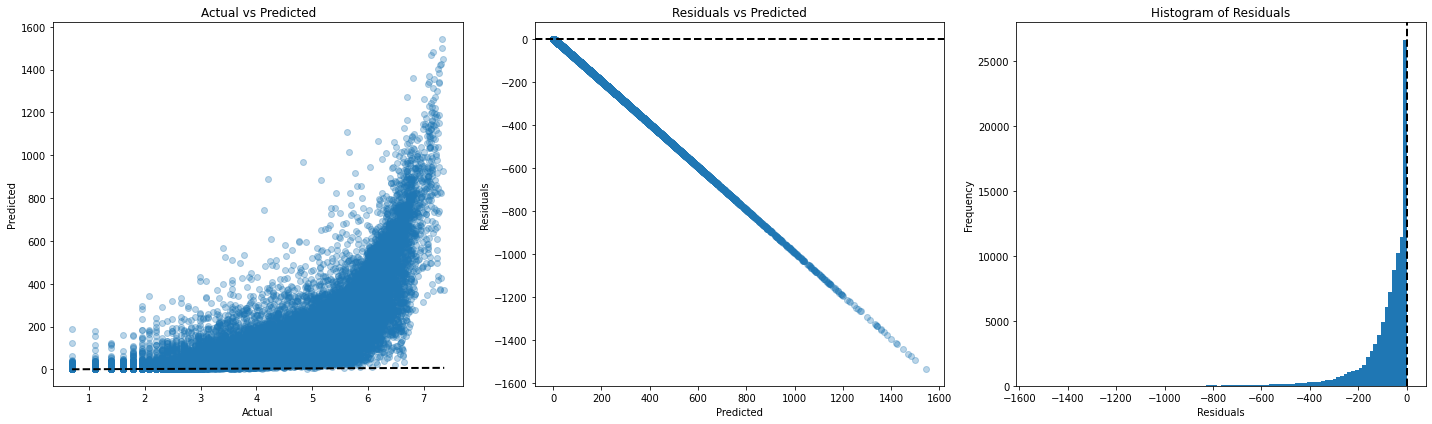

In [ ]:
# evaluation visualisation
model.evaluation_vis(y_test_log, y_pred_log)

### Model 3: Random Forest, Standandardised Demand

In [ ]:
# test and train split with standardisation by dock station
x_train_stand, y_train_stand, x_test_stand, y_test_stand = model.train_test_split(journey_train, journey_test, standardise=True)

In [ ]:
# fit and predict
rf.fit(x_train_stand, y_train_stand)
y_pred_stand = rf.predict(x_test_stand)

In [ ]:
# evaluation metrics
rmse_stand, mae_stand, r2_stand = model.evaluation_metrics(y_test_stand, y_pred_stand)

print('RMSE:', rmse_stand)
print('MAE:', mae_stand)
print('R2 Score:', r2_stand)

RMSE: 0.032780155972454324
MAE: 0.01654479913444593
R2 Score: 0.7817375741474


In [ ]:
# feature importance
print(model.get_feature_importance(rf, x_train_stand))

                                       Feature  Importance
1                                         hour    0.440604
19                                day_of_month    0.080782
7                                      tempmax    0.046634
0                                  day_of_week    0.038324
3                                  part_of_day    0.035379
2                                   is_weekend    0.034302
15                                  cloudcover    0.019292
14                                   windspeed    0.017915
11                                    humidity    0.016351
20                                 day_of_year    0.016086
62                distance_work_5km_10km_ratio    0.014947
18                              daylight_hours    0.014217
8                                      tempmin    0.013503
12                                      precip    0.013420
16                                  visibility    0.012950
59                            business_density    0.0123

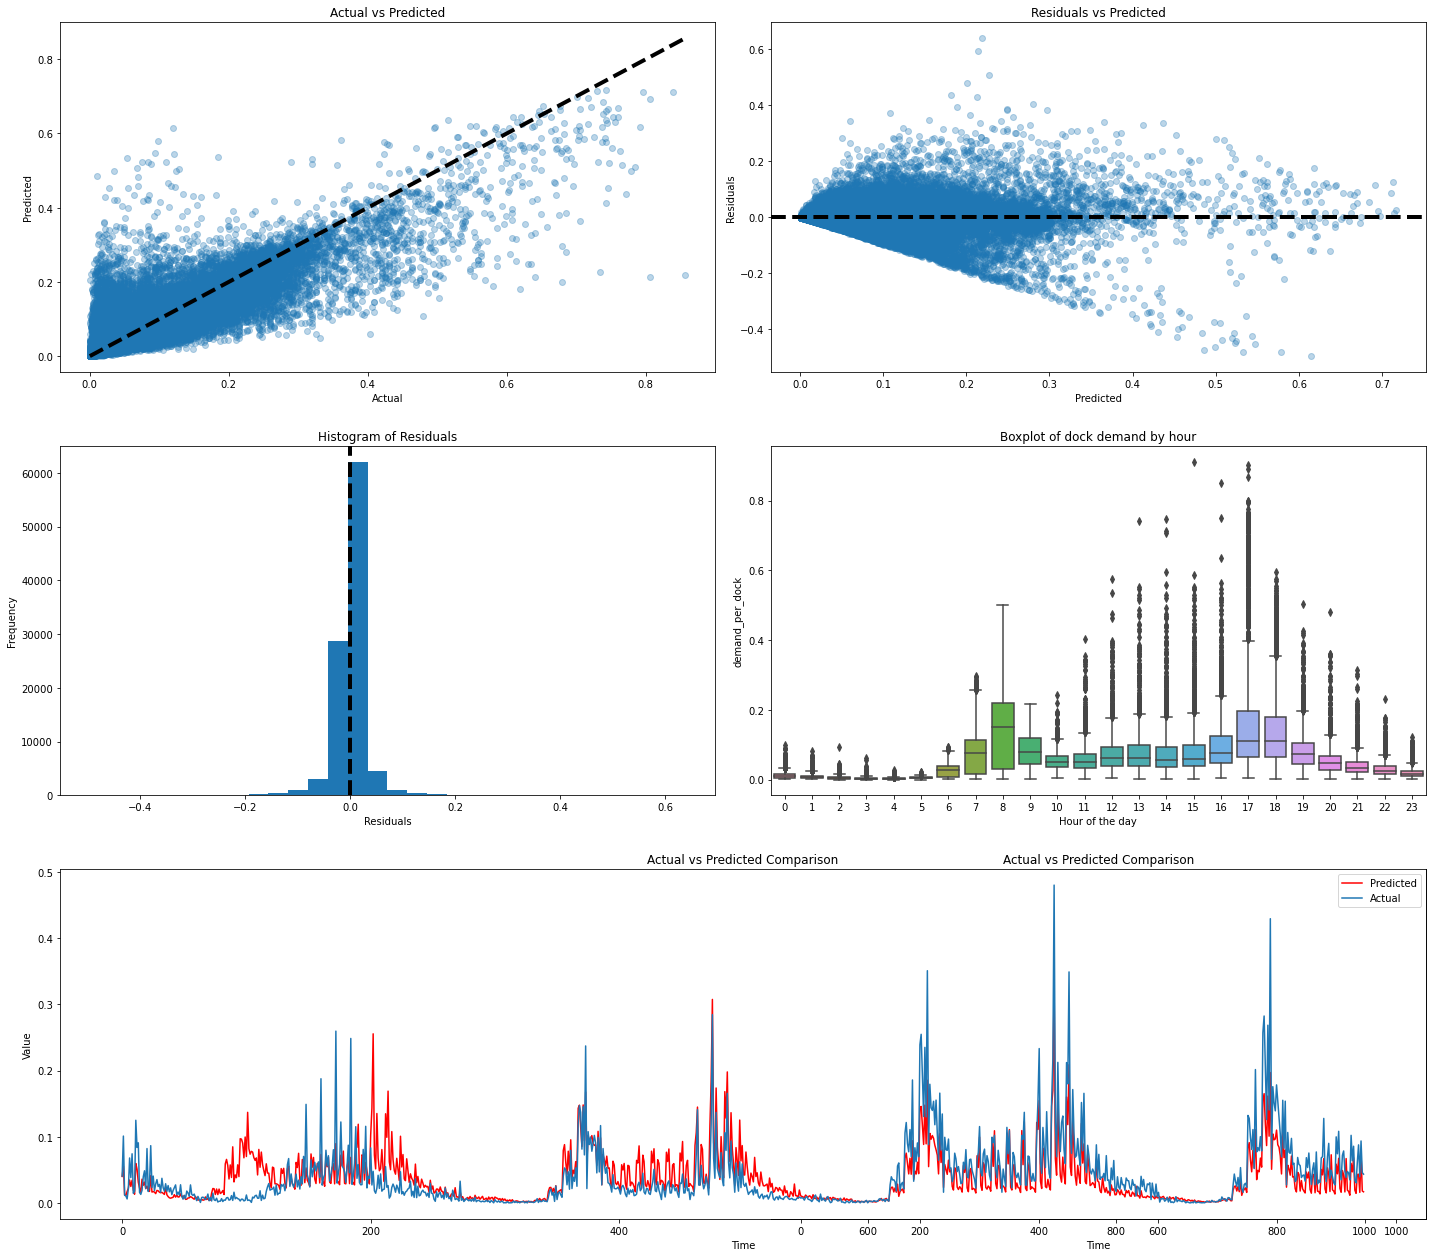

In [ ]:
# evaluation visualisation
model.evaluation_vis(y_test_stand, y_pred_stand)

In [ ]:
# investigate elements with highest errors
df_errors = model.get_enornous_entrie(y_test_stand, y_pred_stand, x_test_stand)
df_errors.head(10)

### Model 4: Gradient Boosting

In [ ]:
# hyperparameter tuning
random_search = model.hyper_param_tuning_gb(x_train, y_train, 10, 3)


# print or log all tried parameters and their scores
params_gb = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
print(params.head(10))


# predict on the test set using the best model
gb = random_search.best_estimator_
y_pred_gb = gb.predict(x_test)

In [ ]:
# evaluation metrics
rmse, mae, r2 = model.evaluation_metrics(y_test, y_pred_gb)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

In [ ]:
# feature importance
print(model.get_feature_importance(gb, x_train).to_string())

In [ ]:
# evaluation visualisation
model.evaluation_vis(y_test, y_pred_gb)

In [ ]:
# visualisation: pred vs actual
model.evaluation_actual_vs_predicted(y_test, y_pred_gb, journey_test, 'All_Boroughs', 'model_gradient_boosting')

In [ ]:
# investigate elements with highest errors
df_errors = model.get_enornous_entrie(y_test, y_pred_gb, x_test)
df_errors.head(10)

In [ ]:
# visualize random search results
model.visualize_random_search_rf(random_search)